In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from scipy.special import j1  # Bessel function
import lmfit

# Données connues

In [2]:
f2 = 150 # en mm, lentille extérieure
na = 0.4 # aperture

lamb = 405 # en nm, laser bleu
M_theo = 20
pixel_size = 3.45 # en um, x et y
cam_width = 1440
cam_height = 1080

poisson_lamb = 400

# Magnification réelle

In [3]:
M = (150*M_theo)/160
M

18.75

# Taille effective des pixels dans le plan de l'objet

In [4]:
pxl = pixel_size/M # en um
pxl

0.184

# Grid

In [5]:
x = np.arange(cam_width)
y = np.arange(cam_height)
X, Y = np.meshgrid(x, y)

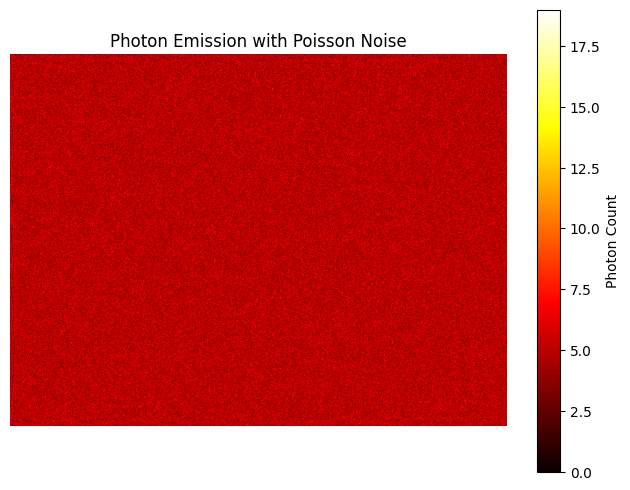

In [6]:
mean_photon_count = 5  # Average photons per pixel
intensity_grid = np.random.poisson(mean_photon_count, (cam_height, cam_width))

# Visualize the intensity grid
plt.figure(figsize=(8, 6))
plt.imshow(intensity_grid, cmap="hot")
plt.colorbar(label="Photon Count")
plt.title("Photon Emission with Poisson Noise")
plt.axis("off")
plt.show()

# PSF

In [7]:
def psf(xx, yy, particle_pos, na, lamb, effective_pixel_size):
    
    # s'assurer que tout est en um
    px, py = particle_pos
    x_um = (xx - px) * effective_pixel_size
    y_um = (yy - py) * effective_pixel_size
    r = np.sqrt(x_um**2 + y_um**2)  # Distance en um

    # Wave vector
    k = 2 * np.pi * na / (lamb * 1e-3)  # Wavelength en um

    # Airy disk
    psf = np.zeros_like(r)
    nonzero_indices = r > 0
    psf[nonzero_indices] = ((2 * j1(k * r[nonzero_indices]) / (k * r[nonzero_indices])) ** 2)
    psf[r == 0] = 1  # traitement de la singularite

    return psf

# Emission de photons

In [8]:
particle_loc = (500, 300) # localisation en pixels
psf_values = psf(X, Y, particle_loc, na, lamb, pxl)

# somme des probas à 1
psf_values /= psf_values.sum()
psf_flat = psf_values.flatten()

In [9]:
# Simulate photon count based on Poisson distribution
num_simulations = np.random.poisson(poisson_lamb)
for _ in range(num_simulations):
    index = np.random.choice(len(psf_flat), p=psf_flat)
    
    random_x = X.flatten()[index]
    random_y = Y.flatten()[index]
    
    # Find the nearest grid indices
    grid_x_idx = np.argmin(np.abs(x - random_x))
    grid_y_idx = np.argmin(np.abs(y - random_y))
    
    # Count photon emission
    intensity_grid[grid_y_idx, grid_x_idx] += 1

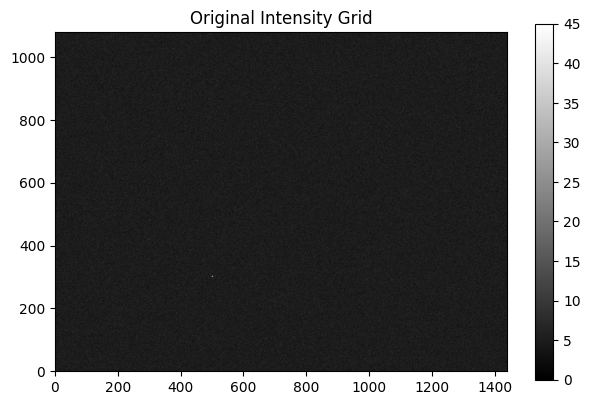

In [10]:
plt.figure(figsize=(12,4))

# Original intensity grid with a cross at the mean of the Gaussian (from the fit)
plt.subplot(1, 2, 1)
plt.imshow(intensity_grid, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='gray')
plt.title('Original Intensity Grid')
plt.colorbar()
plt.tight_layout()

In [11]:
def zoom(grid, loc):
    return grid[loc[1]-10 : loc[1]+11, loc[0]-10 : loc[0]+11]

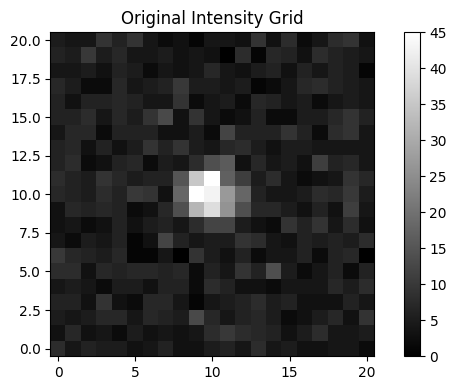

In [12]:
plt.figure(figsize=(12,4))

# Original intensity grid with a cross at the mean of the Gaussian (from the fit)
plt.subplot(1, 2, 1)
plt.imshow(zoom(intensity_grid, particle_loc), origin='lower', cmap='gray')
plt.title('Original Intensity Grid')
plt.colorbar()
plt.tight_layout()

# Fit de Gaussienne

In [13]:
def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, offset):
    x, y = xy
    a = 1 / (2 * sigma_x**2)
    b = 1 / (2 * sigma_y**2)
    return offset + amplitude * np.exp(- (a * (x - x0)**2 + b * (y - y0)**2))

In [14]:
def prepare_data(x, y, z):
    return (x.flatten(), y.flatten()), z.flatten()

In [15]:
(xdata, ydata), zdata = prepare_data(X, Y, intensity_grid)

# Create lmfit model and initial parameters
model = lmfit.Model(gaussian_2d)

# Find the indices of the maximum intensity
max_idx = np.unravel_index(np.argmax(intensity_grid), intensity_grid.shape)

# Convert the indices to coordinates
initial_x0 = x[max_idx[1]]  # x-coordinate
initial_y0 = y[max_idx[0]]  # y-coordinate

params = model.make_params(
    amplitude=np.max(intensity_grid),
    x0=initial_x0,
    y0=initial_y0,
    sigma_x=10,
    sigma_y=10,
    offset=0
)

# Perform the fit
result = model.fit(zdata, params, xy=(xdata, ydata))

Point moyen = (499.76, 300.04) pixels


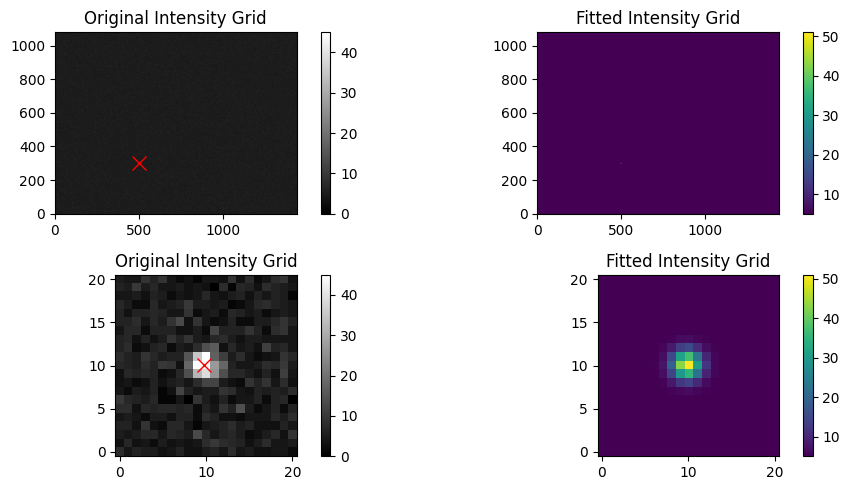

In [16]:
# Plot the original and fitted intensity grids
Z_fit = result.best_fit.reshape(X.shape)

# Extract the fitted parameters for the mean of the Gaussian
x0_fit = result.params['x0'].value
y0_fit = result.params['y0'].value

print(f"Point moyen = ({x0_fit:.2f}, {y0_fit:.2f}) pixels")

# Plot the original and fitted intensity grids using imshow
plt.figure(figsize=(10, 5))

# Original intensity grid with a cross at the mean of the Gaussian (from the fit)
plt.subplot(2, 2, 1)
plt.imshow(intensity_grid, origin='lower', cmap='gray')
plt.title('Original Intensity Grid')
plt.colorbar()YY
plt.plot(x0_fit, y0_fit, 'rx', markersize=10)  # Plot cross at the mean of the Gaussian

# Fitted intensity grid
plt.subplot(2, 2, 2)
plt.imshow(Z_fit, origin='lower', cmap='viridis')
plt.title('Fitted Intensity Grid')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(zoom(intensity_grid, particle_loc), origin='lower', cmap='gray')
plt.title('Original Intensity Grid')
plt.colorbar()
plt.plot(x0_fit-particle_loc[0]+10, y0_fit-particle_loc[1]+10, 'rx', markersize=10)  # Plot cross at the mean of the Gaussian

# Fitted intensity grid
plt.subplot(2, 2, 4)
plt.imshow(zoom(Z_fit, particle_loc), origin='lower', cmap='viridis')
plt.title('Fitted Intensity Grid')
plt.colorbar()

plt.tight_layout()
plt.show()